https://archive.ics.uci.edu/ml/datasets/KDD+Cup+1999+Data

In [1]:
raw_data = sc.textFile('data/kddcup.data_10_percent.gz')

In [9]:
kdd_names = """duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous."""

In [14]:
names = [i.split(':')[0] for i in kdd_names.split('\n')] + ['label']

In [15]:
len(names)

42

In [16]:
raw_data.take(5)

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [3]:
raw_data.count()

494021

In [5]:
def floatOrStr(x):
    try:
        return float(x)
    except ValueError:
        return x

In [17]:
from pyspark.sql import Row

In [21]:
df = spark.createDataFrame(raw_data
 .map(lambda x: [floatOrStr(i) for i in x.split(',')])
 .map(lambda x: Row(**{name: value for name, value in zip(names, x)})))

In [24]:
df.printSchema()

root
 |-- count: double (nullable = true)
 |-- diff_srv_rate: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- dst_host_count: double (nullable = true)
 |-- dst_host_diff_srv_rate: double (nullable = true)
 |-- dst_host_rerror_rate: double (nullable = true)
 |-- dst_host_same_src_port_rate: double (nullable = true)
 |-- dst_host_same_srv_rate: double (nullable = true)
 |-- dst_host_serror_rate: double (nullable = true)
 |-- dst_host_srv_count: double (nullable = true)
 |-- dst_host_srv_diff_host_rate: double (nullable = true)
 |-- dst_host_srv_rerror_rate: double (nullable = true)
 |-- dst_host_srv_serror_rate: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- flag: string (nullable = true)
 |-- hot: double (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- is_host_login: double (nullable = true)
 |-- label: string (nullable = true)
 |-- land: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_access_fi

In [27]:
df.select(['duration', 'protocol_type', 'service']).show(5)

+--------+-------------+-------+
|duration|protocol_type|service|
+--------+-------------+-------+
|     0.0|          tcp|   http|
|     0.0|          tcp|   http|
|     0.0|          tcp|   http|
|     0.0|          tcp|   http|
|     0.0|          tcp|   http|
+--------+-------------+-------+
only showing top 5 rows



In [31]:
from pyspark.sql.types import StringType

In [39]:
string_cols = [i.name for i in df.schema if i.dataType == StringType()]

In [50]:
feature_cols = [i.name for i in df.schema if i.dataType != StringType()]

In [40]:
string_cols.remove('label')

In [41]:
string_cols

['flag', 'protocol_type', 'service']

In [81]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

In [82]:
stages = []
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    one_hot_encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=col+"_vec")
    stages += [indexer, one_hot_encoder]

In [83]:
stages.append(VectorAssembler(inputCols=feature_cols + [col + "_vec" for col in string_cols],
                              outputCol='raw_features'))
stages.append(StandardScaler(withMean=True, inputCol='raw_features', outputCol='features'))

In [47]:
from pyspark.ml import Pipeline

In [84]:
pre_processing = Pipeline(stages=stages).fit(df)

In [56]:
from pyspark.ml.clustering import KMeans

In [85]:
processd = pre_processing.transform(df.sample(False, 0.25))

In [86]:
processd.cache()

DataFrame[count: double, diff_srv_rate: double, dst_bytes: double, dst_host_count: double, dst_host_diff_srv_rate: double, dst_host_rerror_rate: double, dst_host_same_src_port_rate: double, dst_host_same_srv_rate: double, dst_host_serror_rate: double, dst_host_srv_count: double, dst_host_srv_diff_host_rate: double, dst_host_srv_rerror_rate: double, dst_host_srv_serror_rate: double, duration: double, flag: string, hot: double, is_guest_login: double, is_host_login: double, label: string, land: double, logged_in: double, num_access_files: double, num_compromised: double, num_failed_logins: double, num_file_creations: double, num_outbound_cmds: double, num_root: double, num_shells: double, protocol_type: string, rerror_rate: double, root_shell: double, same_srv_rate: double, serror_rate: double, service: string, src_bytes: double, srv_count: double, srv_diff_host_rate: double, srv_rerror_rate: double, srv_serror_rate: double, su_attempted: double, urgent: double, wrong_fragment: double, f

In [ ]:
for k in range(10, 110, 10):
    

In [87]:
knn_model = KMeans().setK(10).fit(processd)

In [88]:
knn_model.computeCost(processd)

10275450.465080425

In [94]:
ks = range(20, 220, 20)
costs = [KMeans().setK(k).fit(processd).computeCost(processd) for k in ks]

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

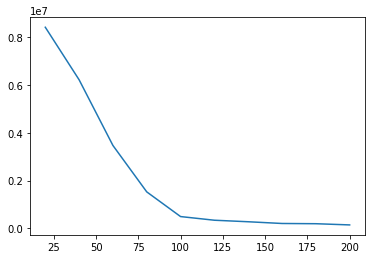

In [96]:
plt.plot(ks, costs)

In [98]:
model = KMeans().setK(110).fit(processd)

In [100]:
model.hasSummary

True

In [104]:
model.summary.predictions

DataFrame[count: double, diff_srv_rate: double, dst_bytes: double, dst_host_count: double, dst_host_diff_srv_rate: double, dst_host_rerror_rate: double, dst_host_same_src_port_rate: double, dst_host_same_srv_rate: double, dst_host_serror_rate: double, dst_host_srv_count: double, dst_host_srv_diff_host_rate: double, dst_host_srv_rerror_rate: double, dst_host_srv_serror_rate: double, duration: double, flag: string, hot: double, is_guest_login: double, is_host_login: double, label: string, land: double, logged_in: double, num_access_files: double, num_compromised: double, num_failed_logins: double, num_file_creations: double, num_outbound_cmds: double, num_root: double, num_shells: double, protocol_type: string, rerror_rate: double, root_shell: double, same_srv_rate: double, serror_rate: double, service: string, src_bytes: double, srv_count: double, srv_diff_host_rate: double, srv_rerror_rate: double, srv_serror_rate: double, su_attempted: double, urgent: double, wrong_fragment: double, f

In [111]:
pred = model.transform(processd)

In [125]:
from pyspark.ml.linalg import VectorUDT

In [126]:
from pyspark.sql.functions import UserDefinedFunction

In [137]:
from pyspark.ml.linalg import Vectors

In [139]:
centers = [Vectors.dense(x) for x in model.clusterCenters()]

In [144]:
center = UserDefinedFunction(lambda x, y: centers[x] - y, VectorUDT())

In [145]:
pred.select(center(pred['prediction'], pred['features'])).take(10)

[Row(<lambda>(prediction, features)=DenseVector([0.0023, -0.0, 0.1108, 1.6962, 0.056, 0.0285, -1.7979, -0.0186, 0.0095, 1.6422, -0.3264, 0.031, 0.0028, 0.0007, 0.1606, -0.0, 0.0, 0.0, -0.0566, -0.0, 0.0326, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0096, 0.0, -0.0, 0.0015, 0.0033, 0.0045, -1.3626, 0.204, 0.0116, -0.0, 0.0, 0.1491, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0406, -0.0413, 0.0406, 0.0, -0.0597, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0])),
 Row(<lambda>(prediction, features)=DenseVector([0.0146, 0.0014, 0.0408, 0.245, 0.0024, 0.0334, 0.0597, -0.0014, 0.0042, 1.5322, -0.0323, 0.0605, 0.0028, 0.0004, 0.0325, -0.0, 0.0, 0.0, -0.0019, -0.0, 0.0057, -0.0, 0.0, 0.0, -0.0, 0.0, 0